In [1]:
import pickle
from IPython.core.display import display, HTML
import pandas as pd
from bs4 import BeautifulSoup
import requests
import os
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
import time
import sys
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline  
import statsmodels.api as sm
import pandas as pd
import regex as re
import requests
import seaborn as sns
import lxml
from lxml.html.soupparser import fromstring
import numbers
import geopandas as gps
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from re import search
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     KFold, GridSearchCV)
import warnings
warnings.filterwarnings('ignore')

## Import pickled town dataframes

In [50]:
#Import all my pickled town data and combine into one dataframe 

df_greenwich=pd.read_pickle('df_greenwich')
df_rye=pd.read_pickle('df_rye')
df_mamaroneck=pd.read_pickle('df_mamaroneck')
df_scarsdale=pd.read_pickle('df_scarsdale')
df_portchester=pd.read_pickle('df_portchester')
df_armonk=pd.read_pickle('df_armonk')
df_bronxville=pd.read_pickle('df_bronxville')
df_larchmont=pd.read_pickle('df_larchmont')
df_darien=pd.read_pickle('df_darien')
df_total=pd.concat([df_greenwich, df_rye, df_mamaroneck, df_scarsdale, df_portchester, df_armonk, df_bronxville, df_larchmont, df_darien], axis=0, ignore_index=True)

## Clean and combine data

In [51]:
#Clean Price, distance, towns 
Price=[]
for i,val in enumerate(list(df_total['listing_type'])):
    if val =='L': 
        Price.append(df_total['price'][i])
    if val =='S':
        Price.append(df_total['clean_price'][i])
df_total['Price']=Price
df_total['School_Performance_Num']=df_total['School_Perforamnce_Num']
df_total['Avg_Gross_Income'] = df_total['Avg_Gross_Income'].astype(float)
df_total['Median_Household_Income'] = df_total['Avg_Gross_Income'].astype(float)
df_total['town'].astype(str)
clean_town=[]


for i,val in enumerate(list(df_total['town'])):
    if 'Pt Chester' in val: 
        clean_town.append(' Port Chester')
    else:
        clean_town.append(str(df_total['town'][i]))

df_total['town2']=clean_town
#print(clean_town)

town_count_dict=dict(df_total['town2'].value_counts())
df_total['town_count']=df_total['town2'].map(town_count_dict)
mask0=(df_total['town_count']<10)
dropme0=df_total[mask0].index
df_total.drop(dropme0,inplace=True)


#REMOVE OUTLIERS 
outlier_mask=(df_total['Price']>10000000)
dropme_outliers=df_total[outlier_mask].index
df_total.drop(dropme_outliers,inplace=True)

#No house should be more than 50  miles, or less than 5 miles 
mask1 = (df_total['dist_downtown_nyc']<5) | (df_total['dist_downtown_nyc']>50)
dropme1=df_total[mask1].index
df_total0=df_total.copy()
df_total0.drop(dropme1,inplace=True)
print(df_total0.shape)

(3579, 30)


In [52]:
df_total1=df_total0.loc[:,['address', 'beds', 'baths', 'sqft', 'town','town2', 'zipcode', 'Avg_Commute', 'School_Performance_Num', 'Median_Household_Income', 'Avg_Gross_Income', 'listing_type', 'dist_downtown_nyc', 'state', 'Price' ]]
#dftotal1 drops some unnecessary columns from the original 


In [287]:
listing_mask = (df_total1['listing_type']=="S")
drop_sold=df_total1[listing_mask].index
df_total_listed=df_total1.copy()
df_total_listed.drop(drop_sold,inplace=True) 
df_total_listed.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2624 entries, 187 to 3627
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   address                  2624 non-null   object 
 1   beds                     2624 non-null   int64  
 2   baths                    2624 non-null   int64  
 3   sqft                     2624 non-null   int64  
 4   town                     2624 non-null   object 
 5   town2                    2624 non-null   object 
 6   zipcode                  2624 non-null   object 
 7   Avg_Commute              2624 non-null   float64
 8   School_Performance_Num   2624 non-null   float64
 9   Median_Household_Income  2624 non-null   float64
 10  Avg_Gross_Income         2624 non-null   float64
 11  listing_type             2624 non-null   object 
 12  dist_downtown_nyc        2624 non-null   float64
 13  state                    2624 non-null   object 
 14  Price                 

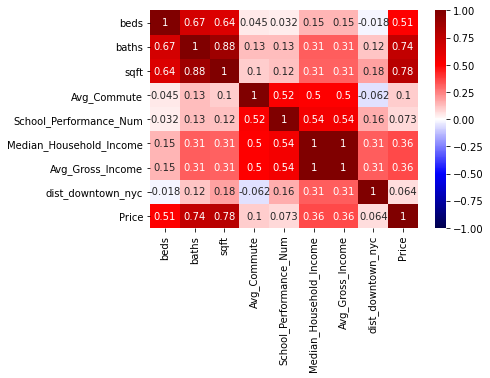

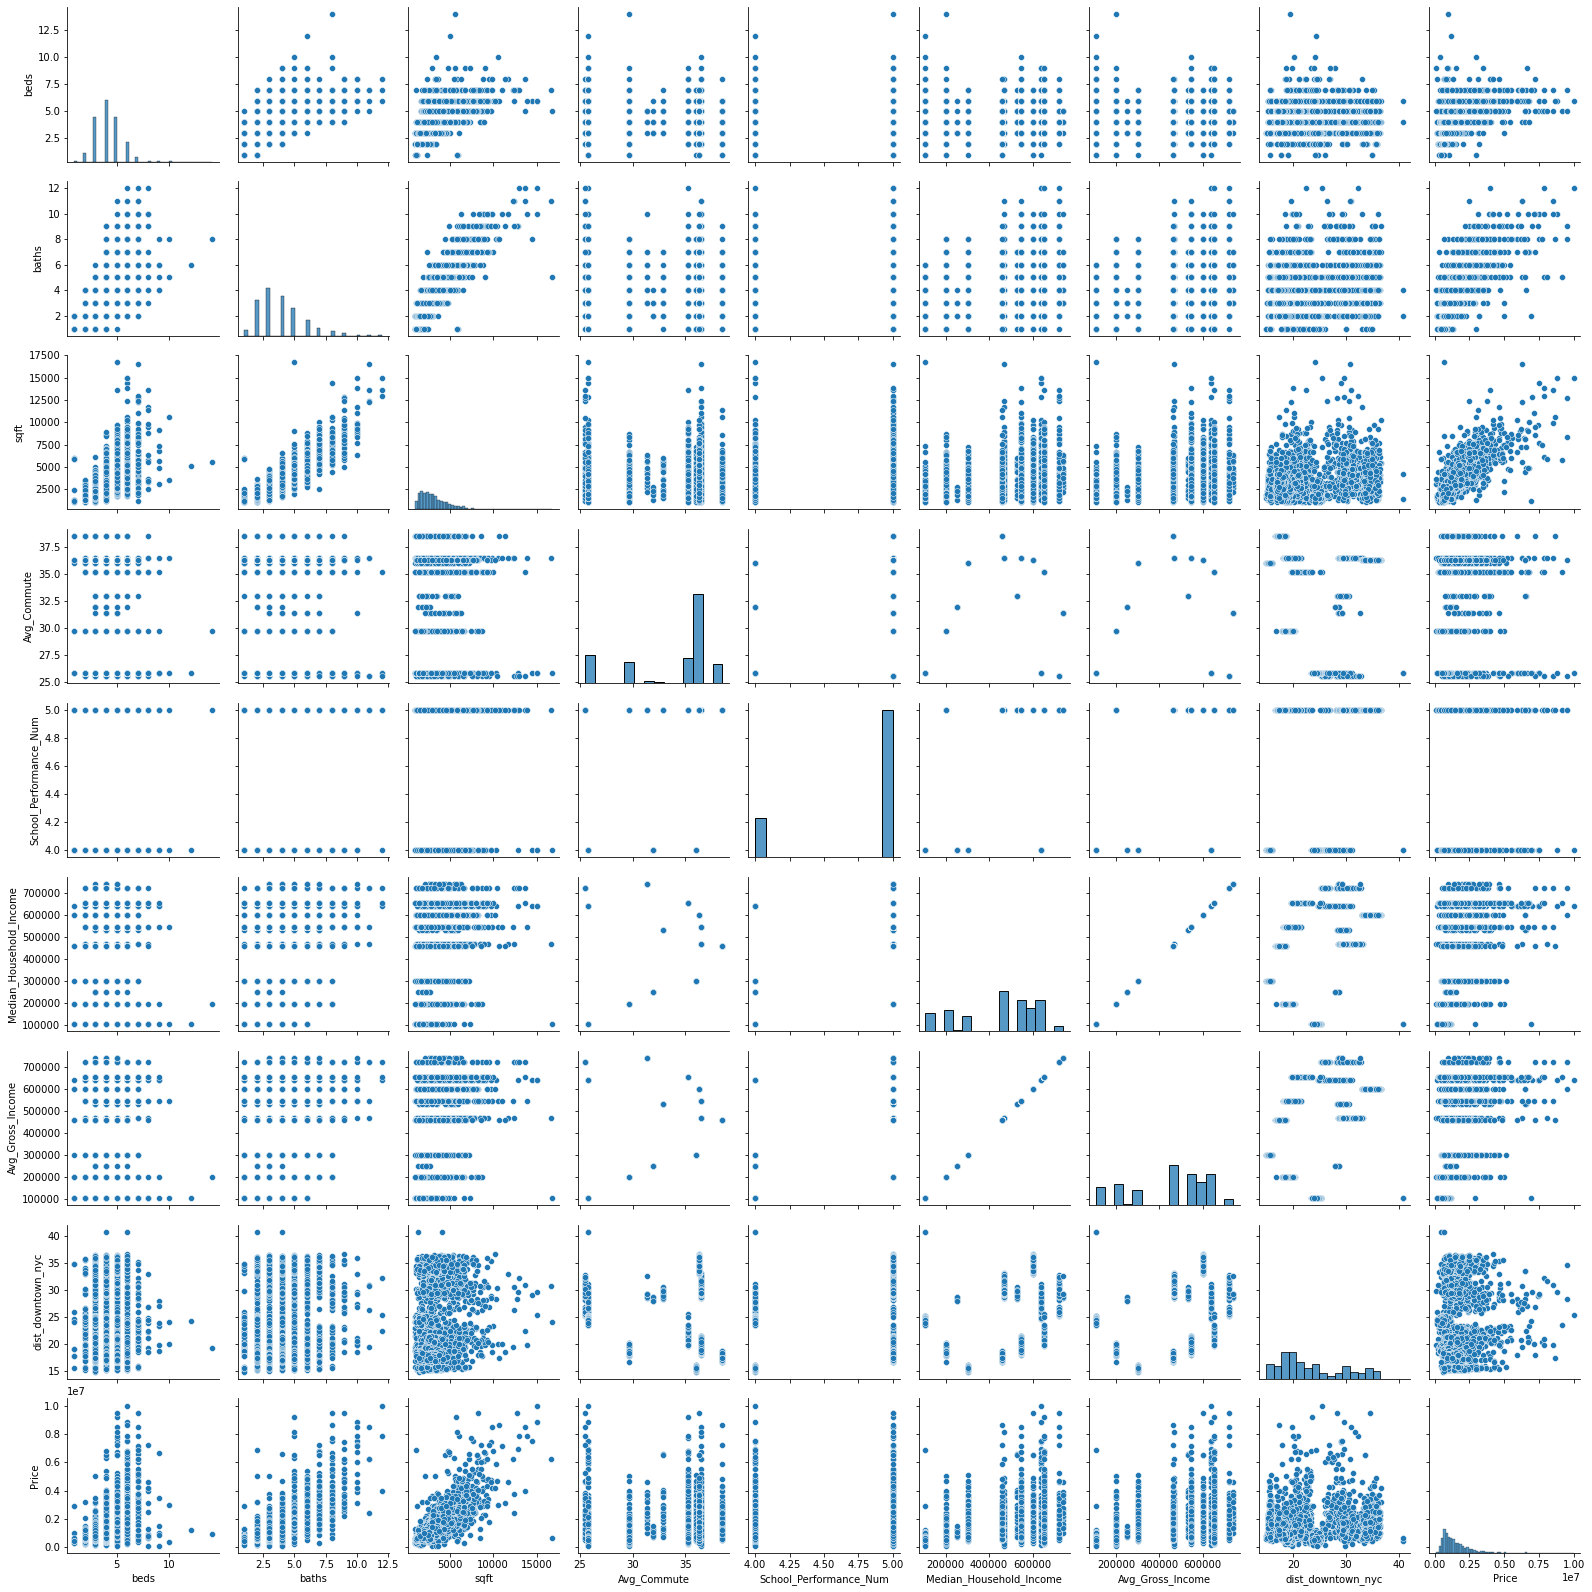

In [54]:
sold_mask = (df_total1['listing_type']=="L")
drop_listings=df_total1[sold_mask].index
df_total_sold=df_total1.copy()
df_total_sold.drop(drop_listings,inplace=True) 
df_total_sold.dropna(inplace=True) #drop null distances 
df_total_sold.info()
df_total_sold.corr()
sns.heatmap(df_total_sold.corr(), cmap='seismic', annot=True, vmin=-1, vmax=1)
sns.pairplot(df_total_sold)

In [149]:
#split out test and train data 
X_overall=df_total_sold.loc[:,['baths','beds','sqft','Avg_Commute','School_Performance_Num', 'Median_Household_Income', 'Avg_Gross_Income', 'dist_downtown_nyc','town2', 'zipcode' ]]
Y_overall=df_total_sold['Price']
X_train, X_test, Y_train, Y_test = train_test_split(X_overall, Y_overall, test_size=0.2,random_state=44)
Y_train.describe()

count    2.099000e+03
mean     1.566655e+06
std      1.176893e+06
min      1.100000e+05
25%      7.800000e+05
50%      1.250000e+06
75%      1.955000e+06
max      9.500000e+06
Name: Price, dtype: float64

## Test a basic OLS on the raw data to start

[0.68361026 0.63968595 0.7243842  0.70883962 0.57702899]
0.6667098049947857


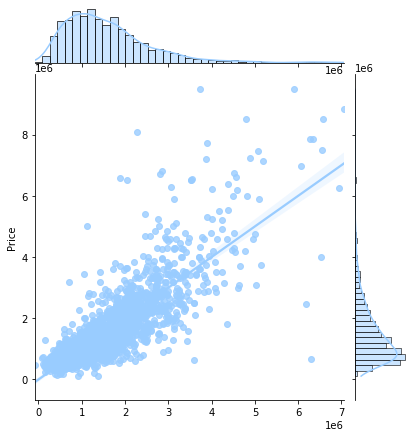

In [164]:
#TEST OUR TRAINING DATA WITH A BASIC LINEAR MODEL TO START... A BASELINE
X_sample=X_train[['baths','beds','sqft','Avg_Commute','School_Performance_Num', 'Median_Household_Income', 'Avg_Gross_Income', 'dist_downtown_nyc']]
Y_sample=Y_train
lm=LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 44)
scorelist_lin0=cross_val_score(lm, X_sample, Y_sample, cv=kf, scoring='r2')
print(scorelist_lin0)
print((scorelist_lin0).mean())
lm.fit(X_sample, Y_sample)
preds=lm.predict(X_sample)
sns.jointplot(x=preds,y=Y_sample, kind='reg', color='#99CCFF')


## Add basic feature engineering and transformation

In [84]:
#SOME FEATURE ENGINEERING AND TRANSFORMATIONS 
X_train_eng=X_train.copy()
#X_train_eng['Baths2']=X_train_eng['baths']**2
X_train_eng['Beds2']=X_train_eng['beds']**2
X_train_eng['school*space']=X_train_eng['School_Performance_Num']*X_train_eng['sqft']
X_train_eng['avg_dist']= X_train_eng[['Avg_Commute','dist_downtown_nyc']].mean(axis=1)
X_train_eng['total_space']=X_train_eng['beds']+X_train_eng['baths']+X_train_eng['sqft']


#ADD DUMMY FEATURE VARS FOR ZIPCODE AND TOWN
X_train_eng=pd.get_dummies(X_train_eng)

#TRANSFORMATION ON Y 
Y_train_eng= Y_train.copy()
Y_train_eng = np.log(Y_train)

[0.75323881 0.73951418 0.81659242 0.76451112 0.68798526]
0.7523683573669065


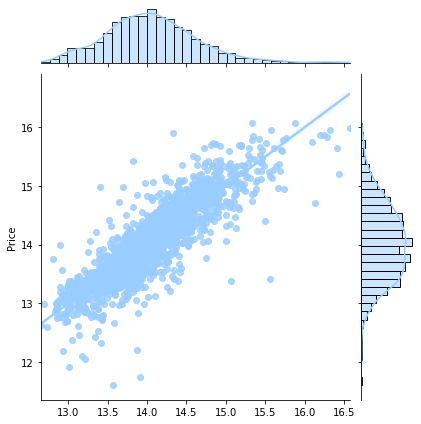

In [165]:
#BUILD A MODEL ON OUR TRANSFORMED AND ENGINEERED TRAINING DATA
Y=Y_train_eng
X=X_train_eng

lm=LinearRegression()
kf = KFold(n_splits=5, shuffle=True, random_state = 44)
scorelist_lin=cross_val_score(lm, X, Y, cv=kf, scoring='r2')
print(scorelist_lin)
print(scorelist_lin.mean())

lm.fit(X, Y)
preds=lm.predict(X)
sns.jointplot(x=preds,y=Y, kind='reg', color='#99CCFF')

## Apply same enginerring/transformation on our heldout test data

In [86]:
#When we have improved this enough
#apply our new features to our test data that is being witheld (and our sold data) 


X_test_eng=X_test.copy()
#FEATURES
#X_test_eng['Baths2']=X_test_eng['baths']**2
X_test_eng['Beds2']=X_test_eng['beds']**2
X_test_eng['school*space']=X_test_eng['School_Performance_Num']*X_test_eng['sqft']
X_test_eng['avg_dist']= X_test_eng[['Avg_Commute','dist_downtown_nyc']].mean(axis=1)
X_test_eng['total_space']=X_test_eng['beds']+X_test_eng['baths']+X_test_eng['sqft']
#DUMMIES
X_test_eng=pd.get_dummies(X_test_eng)
#Y TRANSFORM
Y_test_eng=Y_test.copy()
Y_test_eng = np.log(Y_test)


#also standardize 
#X_te = std.transform(X_test_eng.values)

## Regularized models; standardize features, solve for alphas, train a lasso and ridge model

In [87]:
#REGULARIZATION OF TRAINING DATA 
std = StandardScaler()
std.fit(X.values)
X_tr=std.transform(X.values)

In [88]:
#REGULARIZATION OF TEST DATA 
std = StandardScaler()
std.fit(X.values)
X_te=std.transform(X_test_eng.values)
Y_te=Y_test_eng

In [89]:
#Solve for optimal alphas 
alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, Y)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, Y)


print('Ridge Alpha:', ridge_model.alpha_)
print('Lasso Alpha:', lasso_model.alpha_)

Ridge Alpha: 14.992684327860456
Lasso Alpha: 0.01


In [303]:
#Lasso Coeffs on train
lasso_coefs= list(zip(X.columns, lasso_model.coef_))
#Ridge Coeffs on train
ridge_coefs= list(zip(X.columns, ridge_model.coef_))
lasso_coefs

[('baths', 0.20090487269311613),
 ('beds', 0.008707532738222045),
 ('sqft', 0.26432001545150124),
 ('Avg_Commute', 0.0),
 ('School_Performance_Num', -0.0),
 ('Median_Household_Income', 0.096098000144074),
 ('Avg_Gross_Income', 5.602421284816417e-16),
 ('dist_downtown_nyc', -0.0),
 ('Beds2', -0.0002573677698303203),
 ('school*space', 0.0),
 ('avg_dist', 0.0),
 ('total_space', 0.0),
 ('town2_ Armonk', -0.07282801951388812),
 ('town2_ Bronxville', 0.06584770376979922),
 ('town2_ Cos Cob', 0.0006293297495862152),
 ('town2_ Darien', 0.0),
 ('town2_ Greenwich', 0.0),
 ('town2_ Larchmont', 0.03397617072158028),
 ('town2_ Mamaroneck', -0.0),
 ('town2_ Old Greenwich', 0.03709563026345924),
 ('town2_ Port Chester', -0.10349824795366387),
 ('town2_ Riverside', 0.008605301758045827),
 ('town2_ Rye', 0.018374084648826942),
 ('town2_ Scarsdale', -0.0),
 ('zipcode_06807', 0.0012187224221873547),
 ('zipcode_06820', 0.0),
 ('zipcode_06830', 0.007192658320023833),
 ('zipcode_06831', -0.01367150048300945

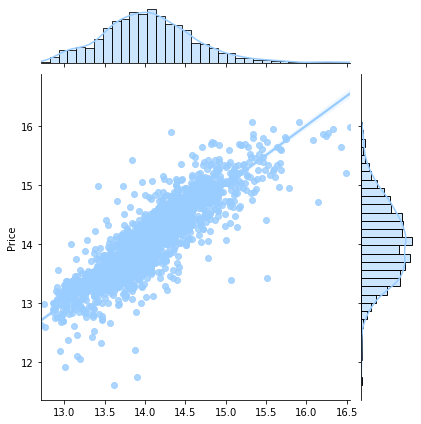

In [167]:
#ridge example on train
preds = ridge_model.predict(X_tr) 
sns.jointplot(x=preds,y=Y, kind='reg',color='#99CCFF')


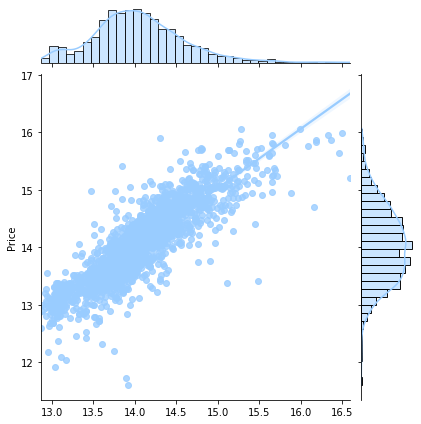

In [168]:
#Lasso example on train
preds = lasso_model.predict(X_tr) 
sns.jointplot(x=preds,y=Y, kind='reg',color='#99CCFF')

In [93]:
#CV OF RIDGE AND LASSO on train 
X_cv,Y_cv = np.array(X_tr), np.array(Y)

kf = KFold(n_splits=5, shuffle=True, random_state = 44)
cv_lm_reg_r2s, cv_lm_lasso_r2s = [], []

for train_ind, val_ind in kf.split(X_cv, Y_cv):
    X_train, y_train = X_cv[train_ind], Y_cv[train_ind]
    X_val, y_val = X_cv[val_ind], Y_cv[val_ind]
    
    lm_reg = Ridge(alpha=ridge_model.alpha_)
    lm_lasso = Lasso(alpha=lasso_model.alpha_)
    
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    lm_reg.fit(X_train_scaled, y_train)
    cv_lm_reg_r2s.append(lm_reg.score(X_val_scaled, y_val))
    
    lm_lasso.fit(X_train_scaled, y_train)
    cv_lm_lasso_r2s.append(lm_lasso.score(X_val_scaled, y_val))
    
    

print('Ridge scores: ', cv_lm_reg_r2s)
print('Lasso scores: ', cv_lm_lasso_r2s, '\n')

print(f'Ridge mean cv r^2: {np.mean(cv_lm_reg_r2s):.3f} +- {np.std(cv_lm_reg_r2s):.3f}')
print(f'Lasso mean cv r^2: {np.mean(cv_lm_lasso_r2s):.3f} +- {np.std(cv_lm_lasso_r2s):.3f}')

Ridge scores:  [0.7538021860062599, 0.7415592942309875, 0.8217962157428439, 0.7617431054982565, 0.6951803879637231]
Lasso scores:  [0.7444187642064355, 0.7264166558113847, 0.8032262680911197, 0.7404722479893413, 0.6843266462952482] 

Ridge mean cv r^2: 0.755 +- 0.041
Lasso mean cv r^2: 0.740 +- 0.038


In [205]:
#ridge and lasso summary scores 
print('ridge test', lm_reg.score(X_te, Y_te))
print('ridge train',lm_reg.score(X_tr, Y))
print('lasso test', lm_lasso.score(X_te, Y_te))
print('lasso train',lm_lasso.score(X_tr, Y))

ridge test 0.6841207038771717
ridge train 0.7545544319459239
lasso test 0.6640493439024902
lasso train 0.7491256203893996


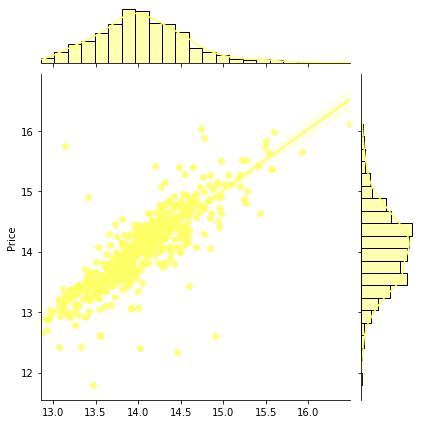

In [171]:
#RIDGE ON TEST
preds = lm_reg.predict(X_te) 
sns.jointplot(x=preds,y=Y_te, kind='reg', color='#FFFF66')

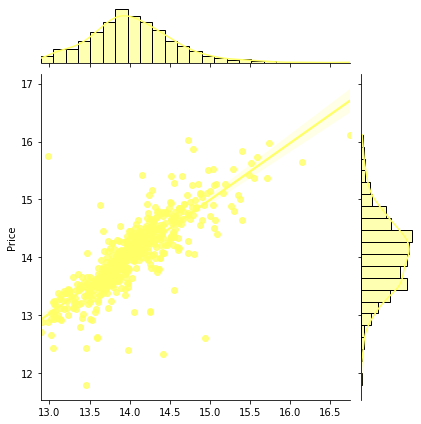

In [172]:
#LASSO ON TEST
preds = lm_lasso.predict(X_te) 
sns.jointplot(x=preds,y=Y_te, kind='reg', color='#FFFF66')

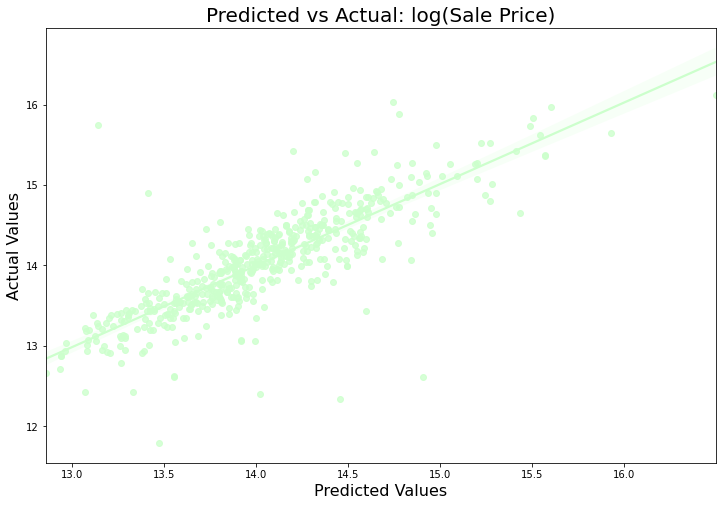

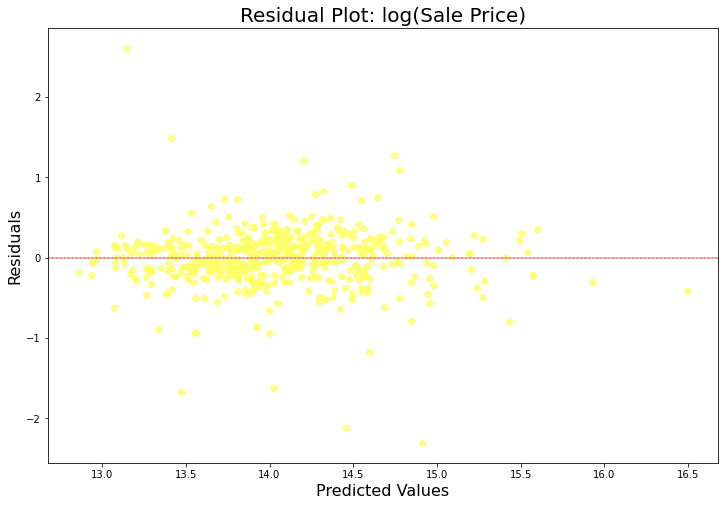

In [179]:
preds = lm_reg.predict(X_te) 
plt.figure(figsize=(12,8))
p1 = sns.regplot(preds, Y_te, color='#CCFFCC');
p1.set_title('Predicted vs Actual: log(Sale Price)', fontsize=20)
p1.set_xlabel(xlabel='Predicted Values', fontsize=16)
p1.set_ylabel(ylabel='Actual Values', fontsize=16)
plt.figure(figsize=(12,8))
p2 = sns.residplot(preds, Y_te, color = '#FFFF66')
p2.set_title('Residual Plot: log(Sale Price)', fontsize=20)
p2.set_xlabel('Predicted Values', fontsize=16)
p2.set_ylabel('Residuals',fontsize=16)
p2.axhline(0, color='#FF9999')


0.6841207038771717


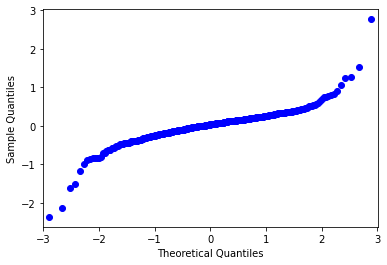

In [131]:
#QQ plot of my ridge on my test data 
#lm_reg.fit(X_te, Y_te)
print(lm_reg.score(X_te, Y_te))
pred=ridge_model.predict(X_te) 
residual=(Y_te-pred)
fig=sm.qqplot(residual)

## Statistics

In [217]:
import math 
preds = lm_reg.predict(X_te) 
lasso_preds = lasso_model.predict(X_te)
#lin_preds=lm.predict(X_te)

def SSE(actuals, preds): 
    return np.sum((actuals - preds)**2)
def RMSE(actuals, preds): #root mean squared error
    return np.sqrt(np.mean((math.e**actuals - math.e**preds)**2))
def MAE(actuals, preds): #mean absolute error
    return np.mean(np.abs(math.e**actuals-math.e**preds))


print('Ridge SSE: ', SSE(Y_te,preds)) 
print('Ridge RMSE: ', RMSE(Y_te,preds))
print('Ridge MAE: ', MAE(Y_te,preds))
print('-----')
print('Lasso SSE: ', SSE(Y_te,lasso_preds)) 
print('Lasso RMSE: ', RMSE(Y_te,lasso_preds))
print('Lasso MAE: ', MAE(Y_te,lasso_preds))



Ridge SSE:  68.87873355966573
Ridge RMSE:  766773.7284815488
Ridge MAE:  392364.06997016806
-----
Lasso SSE:  72.56969145511854
Lasso RMSE:  843945.5427364792
Lasso MAE:  413023.4359946422


## Breakout towns and calculate individual MAEs

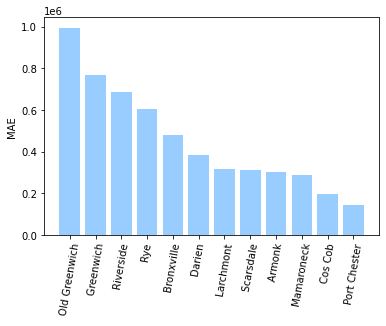

[(' Old Greenwich', 994768.9518260645), (' Greenwich', 766981.2079794464), (' Riverside', 687727.9719469773), (' Rye', 605950.2267409596), (' Bronxville', 479524.60392516747), (' Darien', 382996.7074395978), (' Larchmont', 314604.2979898077), (' Scarsdale', 313593.62598394026), (' Armonk', 300295.538482466), (' Mamaroneck', 285399.2394959158), (' Cos Cob', 195860.12085571996), (' Port Chester', 141962.93533065025)]


In [290]:
X_total=df_total_sold.loc[:,['baths','beds','sqft','Avg_Commute','School_Performance_Num', 'Median_Household_Income', 'Avg_Gross_Income', 'dist_downtown_nyc','town2', 'zipcode' ]]
Y_total=df_total_sold['Price']
X_total_og=X_total.copy()
X_total['Beds2']=X_total['beds']**2
X_total['school*space']=X_total['School_Performance_Num']*X_total['sqft']
X_total['avg_dist']= X_total[['Avg_Commute','dist_downtown_nyc']].mean(axis=1)
X_total['total_space']=X_total['beds']+X_total['baths']+X_total['sqft']
X_total=pd.get_dummies(X_total)
Y_total=np.log(Y_total)
std = StandardScaler()
std.fit(X_total.values)
X_total_std=std.transform(X_total.values)
preds=lm_reg.predict(X_total_std)

X_total_og['preds']=preds
X_total_og['acts']=(Y_total)

town_list=list(df_total_sold.town2.unique())
MAE_list=[]
Average_home_price=[]

for town in town_list: 
    town_filter=(X_total_og['town2']==town)
    town_subset=X_total_og[town_filter]
    preds=town_subset['preds']
    acts=town_subset['acts']
    MAE_list.append((town,MAE(acts, preds)))
    Average_home_price.append((town,np.mean(math.e**acts)))
    
MAE_list.sort(key=lambda x: x[1], reverse=True)
towns = list(zip(*MAE_list))[0]
MAE_scores = list(zip(*MAE_list))[1]

plt.bar(towns, MAE_scores, align='center', color= '#99CCFF')
plt.xticks(towns, rotation =80 ) 
plt.ylabel('MAE')

plt.show()


print(MAE_list)

## Find currently listed houses with largest absolute error

In [302]:
X_total_listed=df_total_listed.loc[:,['baths','beds','sqft','Avg_Commute','School_Performance_Num', 'Median_Household_Income', 'Avg_Gross_Income', 'dist_downtown_nyc','town2', 'zipcode' ]]

X_listed_addresses=df_total_listed['address']
Y_total_listed=df_total_listed['Price']
X_total_listed_og=X_total_listed.copy()
X_total_listed['Beds2']=X_total_listed['beds']**2
X_total_listed['school*space']=X_total_listed['School_Performance_Num']*X_total_listed['sqft']
X_total_listed['avg_dist']= X_total_listed[['Avg_Commute','dist_downtown_nyc']].mean(axis=1)
X_total_listed['total_space']=X_total_listed['beds']+X_total_listed['baths']+X_total_listed['sqft']
X_total_listed=pd.get_dummies(X_total_listed)

Y_total_listed=np.log(Y_total_listed)

std = StandardScaler()
std.fit(X_total.values)
X_total_listed_std=std.transform(X_total_listed.values)

preds_listed=lm_reg.predict(X_total_listed_std)

X_total_listed_og['preds_list']=preds_listed
X_total_listed_og['acts_list']=(Y_total_listed)
X_total_listed_og['Absolute_error']=np.abs(math.e**Y_total_listed-math.e**preds_listed)
X_total_listed_og['address']=X_listed_addresses
X_total_listed_og.sort_values('Absolute_error', ascending=True).tail(10)


,baths,beds,sqft,Avg_Commute,School_Performance_Num,Median_Household_Income,Avg_Gross_Income,dist_downtown_nyc,town2,zipcode,preds_list,acts_list,Absolute_error,address
35,5,6,7776,25.8,4.0,638560.0,638560.0,26.094408,Greenwich,06830,15.020381,15.853479,4.338673e+06,"344 Shore Rd, Greenwich, CT 06830"
3245,6,5,5614,36.3,5.0,599920.0,599920.0,33.057800,Darien,06820,14.665159,15.739759,4.511175e+06,"29 Brush Island Rd, Darien, CT 06820"
107,10,6,8888,25.5,5.0,721550.0,721550.0,29.481608,Greenwich,06831,15.477318,16.106832,4.619177e+06,"66 Cherry Valley Rd, Greenwich, CT 06831"
34,6,5,5638,32.9,5.0,530250.0,530250.0,28.605538,Old Greenwich,06870,15.059862,15.978834,5.229315e+06,"200 Shore Rd, Old Greenwich, CT 06870"
19,9,7,6440,25.8,4.0,638560.0,638560.0,24.695561,Greenwich,06830,15.242397,16.117596,5.829293e+06,"61 Byram Shore Rd, Greenwich, CT 06830"
152,6,5,5759,25.5,5.0,721550.0,721550.0,28.569827,Greenwich,06831,14.668900,16.001562,6.552409e+06,"22 Baldwin Farms S, Greenwich, CT 06831"
471,5,5,4964,35.2,5.0,652440.0,652440.0,20.922259,Rye,10580,14.631772,16.012179,6.732973e+06,"945 Forest Ave, Rye, NY 10580"
45,3,3,2596,32.9,5.0,530250.0,530250.0,29.170714,Old Greenwich,06870,14.281426,15.955577,6.906528e+06,"2 Lighthouse Ln, Old Greenwich, CT 06870"
61,12,6,15773,25.8,4.0,638560.0,638560.0,28.805538,Greenwich,06830,16.619360,16.012179,7.513067e+06,"12 Mountain Wood Dr, Greenwich, CT 06830"
8,12,7,16802,25.5,5.0,721550.0,721550.0,32.758667,Greenwich,06831,16.688922,15.856731,9.997281e+06,"4 Cherry Blossom Ln, Greenwich, CT 06831"


# scratch

[]

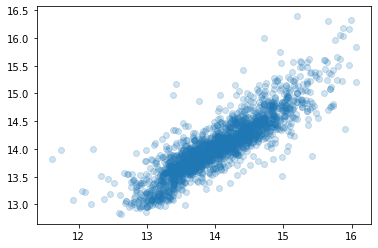

In [300]:
#scatter on training data 
y_train_pred = lm_reg.predict(X_tr)

plt.scatter(Y, y_train_pred, alpha=0.2)
plt.plot()
